In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import optuna
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

import optuna.visualization as vis
#  
random_state = 6
np.random.seed(random_state)

In [8]:
# setting up plot style
plot_params = {
    'figure.figsize': (8, 3),
    'font.size': 14,
    'font.family': 'serif',
    'font.weight': 'normal',
    'axes.grid': True,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': '0.5',
    'grid.alpha': '0.3'
}
plt.rcParams.update(plot_params)


## Load data

In [5]:
df_generated = pd.read_csv('./data/train_generated_data.csv')

In [6]:
df_generated.head()

height     width         sxx        sxy         syy     sdrop       mud  \
0  0.103861  1.145663 -102.509086  58.619371 -117.766562  0.483821  0.216681   
1  0.088714  1.304360 -136.062270  51.391037 -126.715571  0.345944  0.447964   
2  0.099706  1.260377 -117.558936  40.972081 -115.529343  0.292719  0.501697   
3  0.115749  1.191782 -128.169036  94.020712 -157.830504  0.571710  0.202831   
4  0.017900  1.108150 -106.350320  29.148969 -101.379323  0.253122  0.324653   

         dc  label  height_width_ratio  normal_stress_diff  friction_product  \
0  0.295842    0.0                 NaN                 NaN               NaN   
1  0.406466    1.0                 NaN                 NaN               NaN   
2  0.389360    1.0                 NaN                 NaN               NaN   
3  0.408976    0.0                 NaN                 NaN               NaN   
4  0.398592    1.0                 NaN                 NaN               NaN   

   stress_ratio  static_dynamic_friction_diff  stress_diff_dynamic_strength  \
0           NaN                           NaN                           NaN   
1           NaN                           NaN                           NaN   
2           NaN                           NaN                           NaN   
3           NaN                           NaN                           NaN   
4           NaN                           NaN                           NaN   

   normalized_dc data_type  
0            NaN     train  
1            NaN     train  
2            NaN     train  
3            NaN     train  
4            NaN     train

### Understand the parameters of the generator

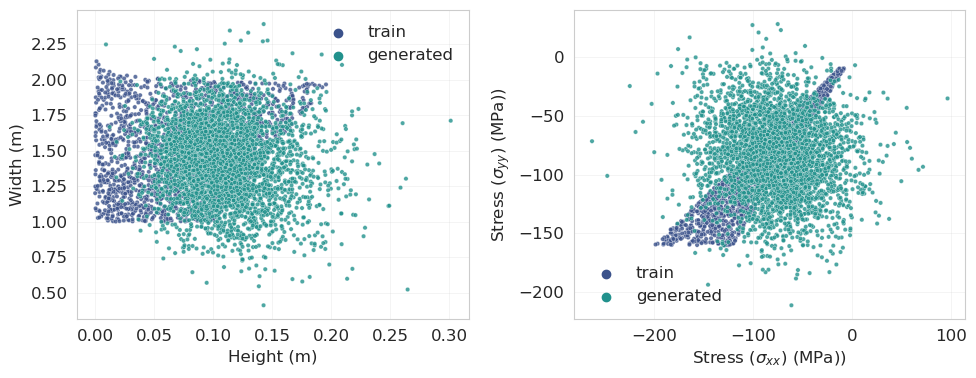

In [9]:
### Scatter plot of the height and width
plt.figure(figsize=(10, 4))
sns.set_style('whitegrid')

plt.subplot(1, 2, 1)
sns.scatterplot(x='height', y='width', data=df_generated, s=10, alpha=0.8, hue='data_type')
plt.xlabel('Height (m)')
plt.ylabel('Width (m)')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
sns.scatterplot(x='sxx', y='syy', data=df_generated,
                s=10, alpha=0.8, hue='data_type')
plt.xlabel('Stress ($\sigma_{xx}$) (MPa))')
plt.ylabel('Stress ($\sigma_{yy}$) (MPa))')

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('./paper/figures/height_width_stress_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

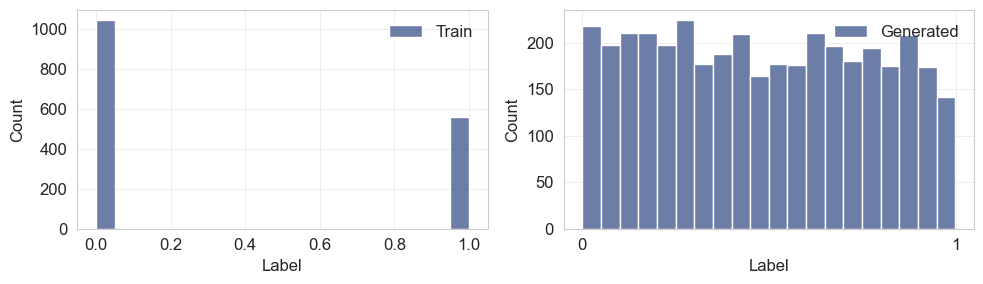

In [21]:
# Plot label distribution plot colored by data type
plt.figure(figsize=(10, 3))
sns.set_style('whitegrid')
plt.subplot(1, 2, 1)
trained = df_generated[df_generated['data_type'] == 'train']
sns.histplot(data=trained, x='label', bins=20, legend=True, label='Train')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
generated = df_generated[df_generated['data_type'] == 'generated']
# Show legend for generated data
sns.histplot(data=generated, x='label', bins=20, legend=True, label='Generated')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1])
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig('./paper/figures/label_histogram.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [52]:
# Plot distribution plot using altaire
alt.Chart(df_generated.sample(4000)).mark_bar().encode(
    alt.X('dc', bin=alt.Bin(maxbins=100)),
    y='count()',
    color='data_type'
).properties(
    width=600,
    height=400
)

alt.Chart(...)

### Understanding the parameters using optimization

In [24]:
train_columns = ['height', 'width', 'sxx', 'sxy',
                 'syy', 'sdrop', 'mud', 'dc']


In [25]:
def create_new_features(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    # Create new features
    df_new['height_width_ratio'] = df_new['height'] / df_new['width']
    df_new['normal_stress_diff'] = df_new['sxx'] - df_new['syy']
    df_new['friction_product'] = df_new['mud'] * (df_new['sdrop'])
    df_new['stress_ratio'] = df_new['sxy'] / df_new['syy']
    df_new['static_dynamic_friction_diff'] = (
        df_new['mud'] + df_new['sdrop']) - df_new['mud']
    df_new['stress_diff_dynamic_strength'] = df_new['sxy'] - \
        (df_new['syy'] * df_new['mud'])
    df_new['normalized_dc'] = df_new['dc'] / df_new['width']
    return df_new


In [26]:
# Pre-trained model
model_path = './models/supervised_model_roc_0.8991_f1_0.8266.txt'
supervised_model = lgb.Booster(model_file=model_path)

# Generateds parameters
gp = df_generated.describe().to_dict()

In [27]:
def objective_function(trial):

    # Define parameter search space
    width = trial.suggest_float("width", gp['width']['min'], gp['width']['max'])
    height = trial.suggest_float("height", gp['height']['min'], gp['height']['max'])
    syy = trial.suggest_float("syy", gp['syy']['min'], gp['syy']['max'])
    sxx = trial.suggest_float("sxx", gp['sxx']['min'], gp['sxx']['max'])
    mud = trial.suggest_float("mud",  gp['mud']['min'], gp['mud']['max'])
    sdrop = trial.suggest_float("sdrop",  gp['sdrop']['min'], gp['sdrop']['max'])
    sxy = trial.suggest_float("sxy",  gp['sxy']['min'], gp['sxy']['max'])
    dc = trial.suggest_float("dc", gp['dc']['min'], gp['dc']['max'])

    # List of all parameters
    params = [height, width, sxx, sxy, syy, sdrop, mud, dc]
    train_columns = ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc']
    
    # Create a dataframe usinf the parameters
    df = pd.DataFrame([params], columns=train_columns)

    df = create_new_features(df)
    score = supervised_model.predict(
        df, num_iteration=supervised_model.best_iteration)

    # Optimize for high strength and low friction coefficient
    return score


In [28]:
# Define the optimization study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=1000, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
# Print the best parameter settings and reward found
best_params = study.best_params
best_reward = study.best_value
print(f"Best parameter settings: {best_params}")
print(f"Best reward: {best_reward}")

Best parameter settings: {'width': 1.2306548835322657, 'height': 0.030525029999435772, 'syy': -159.45556156567267, 'sxx': -186.8546176842998, 'mud': 0.27476593524897963, 'sdrop': 0.4424828842878542, 'sxy': 95.59092083926296, 'dc': 0.5640694623402633}
Best reward: 1.427930065415222


In [34]:
### Plot trilal vs value using altair
# also plot a line that shows the best value found sofar 
alt.Chart(df_study).mark_point().encode(
    x='number',
    y='value',
    color='state'
) + alt.Chart(df_study).mark_line().encode(
    x='number',
    y='best_value',
    color = alt.value('red'),
    tooltip=['number', 'best_value']
).properties(
    width=600,
    height = 300
)

alt.LayerChart(...)

#### Feature importance

In [23]:
importance = optuna.importance.get_param_importances(study)

# OrderedDict to dataframe
df_importance = pd.DataFrame(list(importance.items()), columns=['feature', 'importance'])

In [24]:
## Plot feature importance in sorting order
alt.Chart(df_importance).mark_bar().encode(
    y=alt.Y('feature', sort=None),
    x='importance',
    tooltip=['feature', 'importance']
).properties(
    width=600,
    height = 400
)


alt.Chart(...)

In [ ]:
### Parallel coordinate plot seaborn
df_study['best_value'] = df_study['value'].cummax()
df_study['best_value'] = df_study['best_value'].round(4)
df_study['best_value'] = df_study['best_value'].astype(str)
df_study['best_value'] = df_study['best_value'].str.pad(6, side='left', fillchar='0')
sns.set(style="whitegrid")

In [25]:
# Plot parallel coordinate plot
plot_parallel_coordinate = vis.plot_parallel_coordinate(study)
plot_parallel_coordinate.show()

### Inter feature relationship with probability to propagate

In [26]:
alt.Chart(df_study).mark_rect().encode(
    alt.X('params_height:Q', title='height'),
    alt.Y('params_width:Q', title='width'),
    alt.Color('value:Q', scale=alt.Scale(scheme='greenblue'))
).properties(
    width=600,
    height = 400
)


alt.Chart(...)

In [28]:
# Plot the show the relationship between the parameters using altair
def plot_feature_relatinship(feature1, feature2, feature1_title, feature2_title):
    heatmap = alt.Chart(df_study).mark_rect().encode(
        alt.X(feature1, title=feature1_title),
        alt.Y(feature2, title=feature2_title),
        alt.Color('value:Q', scale=alt.Scale(scheme='greenblue'))
    )

    points = alt.Chart(df_study).mark_circle(
        color = 'red',
        size = 5
        ).encode(
        x=feature1,
        y=feature2,
        tooltip=[feature1, feature2, 'value']
    ).properties(
        width=400,
        height = 200
    )
    
    return heatmap + points


plot_feature_relatinship('params_height', 'params_width', 'Height', 'Width') | plot_feature_relatinship('params_height', 'params_syy', 'Height', 'Syy') | plot_feature_relatinship('params_sxx', 'params_sxy', 'Sxx', 'Sxy') | plot_feature_relatinship('params_sdrop', 'params_mud', 'Sdrop', 'Mud') | plot_feature_relatinship('params_dc', 'params_sxy', 'Dc', 'Sxy')

alt.HConcatChart(...)

In [72]:
df_study_final = df_study[df_study['value'] >0 & (df_study['value']<1)]
df_study_final = df_study_final.dropna(
    subset=['params_height', 'params_width', 'value'])

In [73]:
df_study_final['value'].describe()

count    961.000000
mean       0.942075
std        0.369305
min        0.006095
25%        0.701897
50%        1.023221
75%        1.254631
max        1.427930
Name: value, dtype: float64

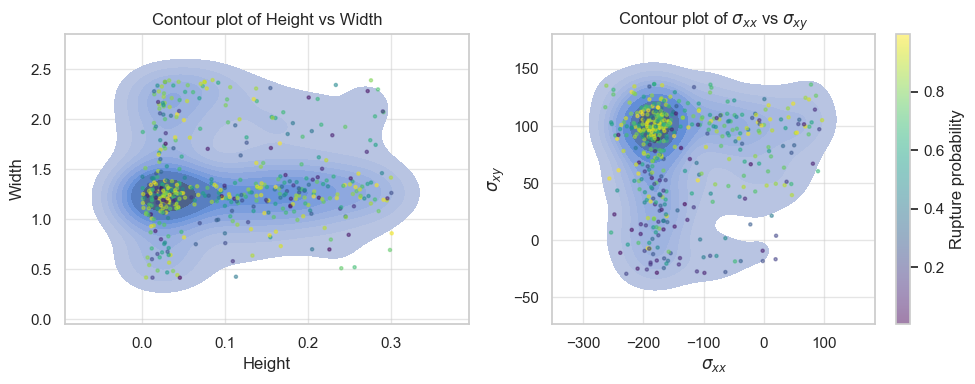

In [83]:
df_study_final = df_study[(df_study['value'] >= 0) & (df_study['value'] <= 1)]
df_study_final = df_study_final.dropna(
    subset=['params_height', 'params_width', 'value'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_study_final,x='params_height',y='params_width',fill=True)
scatter = plt.scatter(df_study_final['params_height'], df_study_final['params_width'],
    c=df_study_final['value'], cmap='viridis',  # use a colormap of your choice
    alpha=0.5, s=5,
)
plt.xlabel('Height')
plt.ylabel('Width')
plt.title('Contour plot of Height vs Width')
# plt.colorbar(scatter)


plt.subplot(1, 2, 2)
sns.kdeplot(data=df_study_final,x='params_sxx',y='params_sxy',fill=True)
scatter = plt.scatter(df_study_final['params_sxx'], df_study_final['params_sxy'],
    c=df_study_final['value'], cmap='viridis',  # use a colormap of your choice
    alpha=0.5, s=5,
)
plt.xlabel('$\sigma_{xx}$')
plt.ylabel('$\sigma_{xy}$')
plt.title('Contour plot of $\sigma_{xx}$ vs $\sigma_{xy}$')
plt.colorbar(scatter, label='Rupture probability')
plt.tight_layout()
plt.savefig('./paper/figures/contour.png', dpi=300, bbox_inches='tight')
plt.show()